# Covid Brasil

In [1]:
%config IPCompleter.greedy=True
#!pip install pandas
#!pip install seaborn
#!pip install plotly
#!pip install altair

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt 
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import altair as alt
print('Modules are imported.')

Modules are imported.


In [2]:
import io
import requests
url='https://data.brasil.io/dataset/covid19/caso.csv.gz'
s=requests.get(url).content


In [3]:
with open('data/covidio.csv.gz', 'wb') as f:
    f.write(s)

In [50]:
#df = pd.read_csv('data/covidio.csv.gz', parse_dates=['last_available_date'], index_col='last_available_date')
df = pd.read_csv('data/covidio.csv.gz')


In [51]:
df.columns

Index(['date', 'state', 'city', 'place_type', 'confirmed', 'deaths',
       'order_for_place', 'is_last', 'estimated_population_2019',
       'estimated_population', 'city_ibge_code',
       'confirmed_per_100k_inhabitants', 'death_rate'],
      dtype='object')

In [52]:
df['mortalidade'] =  df['deaths']/df['estimated_population']
df['mortalidade100k'] = (df['deaths']*100000)/df['estimated_population']
df[['mortalidade', 'death_rate', 'mortalidade100k']].head()

,mortalidade,death_rate,mortalidade100k
0,0.001240,0.0137,124.046588
1,0.001237,0.0137,123.698468
2,0.001235,0.0137,123.466388
3,0.001229,0.0137,122.886189
4,0.001229,0.0138,122.886189


In [69]:
df_states = df[(df['is_last'] == True) &(df.place_type=='state')][['state','confirmed','deaths', 'death_rate','mortalidade','mortalidade100k']]
df_cities = df[(df['is_last'] == True) &(df.place_type=='city')][['city','state', 'confirmed','deaths', 'death_rate','mortalidade','mortalidade100k']]

In [70]:
# deletando linhas inuteis
df_cities.drop(df_cities[df_cities['city'] == 'Importados/Indefinidos'].index, inplace=True)

In [71]:
df_states.columns = ['Estado', 'Confirmados', 'Mortes', 'Letalidade','Mortalidade', 'Mortalidade100k']
df_cities.columns = ['Cidade', 'Estado', 'Confirmados', 'Mortes', 'Letalidade','Mortalidade', 'Mortalidade100k']

In [150]:
#df_cities.sort_values('Letalidade',ascending=False).head()
df_states['Letalidade_rank'] = df_states['Letalidade'].rank(method='min').astype(int)
df_states['Mortalidade_rank'] = df_states['Mortalidade'].rank(method='min').astype(int)
df_states['rank'] = ((df_states['Mortalidade_rank'] + df_states['Letalidade_rank'])/2).rank(method='min').astype(int)
df_cities['Letalidade_rank'] = df_cities['Letalidade'].rank(method='min').astype(int)
df_cities['Mortalidade_rank'] = df_cities['Mortalidade'].rank(method='min').astype(int)
df_cities['rank'] = ((df_cities['Mortalidade_rank'] + df_cities['Letalidade_rank'])/2).rank(method='min').astype(int)

In [156]:
def search_city(city, color='red', reverse=False):
    return df_cities[df['city'] == city]

def style_frame(df):
    cm = sns.light_palette(color, as_cmap=True, reverse=reverse)
    return (df.style.set_properties(**{'text-align': 'right'}).background_gradient(cmap=cm).hide_index()).set_caption(
    title)

def covid_data_table(df, nivel, column, n, asc=False,title="", color='red', reverse=False, corte=0):

    if(corte > 0):
        df = df[df['Mortes'] > corte]
    
    df = df.sort_values(column,ascending=asc).copy().head(n)

    data_table = pd.DataFrame()
    data_table[nivel] = df[nivel]
    if nivel == 'Cidade':
        data_table['Estado'] = df['Estado']
    #data_table["Confirmados"] = df['Confirmados']
    data_table["rank"] = df['rank']
    data_table["Letalidade_rank"] = df['Letalidade_rank']
    data_table["Mortalidade_rank"] = df['Mortalidade_rank']
    data_table["Mortes"] = df['Mortes']
    data_table["Mortalidade100k"] = df['Mortalidade100k'].astype(int)
    data_table["Letalidade"] = df['Letalidade']
    
    #data_table["Mortalidade"] = df['Mortalidade']
    
    cm = sns.light_palette(color, as_cmap=True, reverse=reverse)
    return (data_table.style.set_properties(**{'text-align': 'right'}).background_gradient(cmap=cm).hide_index()).set_caption(
    title)

def tabela_estado(column, n, asc=False,title="", color='red', reverse=False, corte=0):
    '''Retorna uma table para estado '''
    return covid_data_table(df_states,'Estado', column, n, asc=asc,title=title, color=color, reverse=reverse, corte=corte)

def tabela_estado_reversa(column, n, title="", corte=0):
    return tabela_estado(column, n, True, title, 'green', True, corte)

def tabela_cidade(column, n, asc=False,title="", color='red', reverse=False, corte=0):
    '''Retorna uma table para cidades '''
    return covid_data_table(df_cities,'Cidade', column, n, asc=asc,title=title, color=color, reverse=reverse, corte=corte)

def tabela_cidade_reversa(column, n, title="", corte=0):
    return tabela_cidade(column, n, True, title, 'green', True, color='green', reverse=True, corte=corte)

## Top 10 Piores no Ranking (Letalidade + Mortalidade)/2

In [158]:
tabela_estado('rank', 20)

Estado,rank,Letalidade_rank,Mortalidade_rank,Mortes,Mortalidade100k,Letalidade
RJ,27,27,26,30172,173,0.057000
AM,26,25,27,8564,203,0.031300
MT,25,22,24,5214,147,0.023500
SP,23,24,18,53704,116,0.029700
PE,23,26,16,10399,108,0.039200
CE,22,23,17,10556,114,0.027900
ES,21,13,23,5929,145,0.019900
SE,20,14,19,2801,120,0.020100
GO,19,17,15,7599,106,0.021300
DF,17,5,25,4582,149,0.016400


## Top 10 

## Top 20 Cidades com maior letalidade no Brasil!

In [115]:
tabela_cidade_reversa('Mortalidade',20, corte=500)

Cidade,Estado,Confirmados,Mortes,Mortalidade100k,Letalidade,Letalidade_rank,Mortalidade_rank
Rio de Janeiro,RJ,189679,17352,257.149907,0.091500,5525.000000,5551.000000
Manaus,AM,119504,5490,247.344092,0.045900,5198.000000,5544.000000
Santos,SP,36799,1027,236.823657,0.027900,4277.000000,5537.000000
São José do Rio Preto,SP,42708,1045,224.739399,0.024500,3878.000000,5531.000000
Cuiabá,MT,47244,1340,216.784982,0.028400,4326.000000,5520.000000
Rondonópolis,MT,15141,505,213.944976,0.033400,4736.000000,5515.000000
Várzea Grande,MT,14287,615,213.893700,0.043000,5107.000000,5514.000000
Porto Velho,RO,48349,1054,195.418964,0.021800,3507.000000,5484.000000
Vitória,ES,32745,656,179.306009,0.020000,3216.000000,5432.000000
Cariacica,ES,23874,675,175.819253,0.028300,4319.000000,5416.000000


## Top 10 menor letalidade 

In [119]:
covid_data_table_reverse(df_states,'Letalidade', 10,'Top 10 Menor Letalidade')

Estado,Confirmados,Mortes,Letalidade
SC,581352,6416,0.011000
RR,74705,871,0.011700
TO,102790,1391,0.013500
AP,77729,1066,0.013700
DF,278316,4573,0.016400
BA,592770,10176,0.017200
AC,49049,876,0.017900
RO,126766,2281,0.018000
MS,162220,2937,0.018100
PR,556304,10141,0.018200


In [77]:
def covid_bubble_chart(df, column, n, asc=False):
    df = df.sort_values(column,ascending=asc).copy().head(n)
    fig = px.scatter(df, x="Estado", y=column, size=column, color="Estado",
               text="Estado", size_max=90)
    fig.update_layout(
    title="Os top " + str(n) + ' piores estados por '  + column,
    xaxis_title="Estados",
    yaxis_title=column,
    width = 700
    )
    fig.show();
    
covid_bubble_chart(df_states, 'Letalidade',10, True)


In [75]:
covid_bubble_chart(df_states, 'Mortes',10)

In [32]:
datetime_index = pd.DatetimeIndex(df_states.index)
df_states.set_index(datetime_index, inplace=True)

<AxesSubplot:>

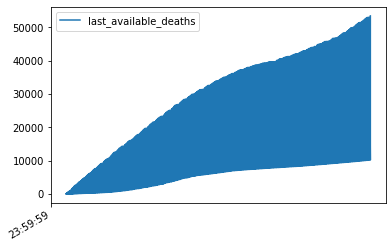

In [36]:
df_states[df_states.state.isin(['SP','MG','BA'])].groupby(['last_available_date'])[['last_available_deaths']].sum().plot()                  

In [8]:
df_states.groupby(['last_available_date','state']).sum().info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8730 entries, (Timestamp('2020-02-25 00:00:00'), 'SP') to (Timestamp('2021-02-02 00:00:00'), 'TO')
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   city_ibge_code                                 8730 non-null   float64
 1   epidemiological_week                           8730 non-null   int64  
 2   estimated_population                           8730 non-null   float64
 3   estimated_population_2019                      8730 non-null   float64
 4   is_last                                        8730 non-null   int64  
 5   is_repeated                                    8730 non-null   int64  
 6   last_available_confirmed                       8730 non-null   int64  
 7   last_available_confirmed_per_100k_inhabitants  8730 non-null   float64
 8   last_available_death_rate                      8730 n

In [ ]:
df

In [53]:
df_states = df[df['place_type']=='state'].copy()
df_cities = df[df['place_type']=='city'].copy()

In [62]:
df_states.groupby(['state'])['last_available_deaths'].sum()

state
AC     154631
AL     482301
AM    1086942
AP     174675
BA    1501613
CE    2151044
DF     692149
ES     863542
GO    1023599
MA     889640
MG    1724143
MS     309816
MT     744411
PA    1592521
PB     641395
PE    1957268
PI     486766
PR    1096319
RJ    4591733
RN     557155
RO     310756
RR     150097
RS    1184728
SC     688566
SE     452750
SP    8339330
TO     202787
Name: last_available_deaths, dtype: int64

In [47]:
df_states[df['state'].str.contains('SP')]['last_available_deaths'].head()

<ipython-input-47-dbc946d00171>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_states[df['state'].str.contains('SP')]['last_available_deaths'].head()


ValueError: cannot reindex from a duplicate axis

In [33]:
df_states.groupby(['last_available_date','state'])[['new_confirmed', 'new_deaths','last_available_confirmed_per_100k_inhabitants']].sum().reset_index

<bound method DataFrame.reset_index of                            new_confirmed  new_deaths  \
last_available_date state                              
2020-02-25          SP                 1           0   
2020-02-26          SP                 0           0   
2020-02-27          SP                 0           0   
2020-02-28          SP                 1           0   
2020-02-29          SP                 0           0   
...                                  ...         ...   
2021-02-02          RS              3255          63   
                    SC              2802          53   
                    SE               424           8   
                    SP             14297         365   
                    TO               442           5   

                           last_available_confirmed_per_100k_inhabitants  
last_available_date state                                                 
2020-02-25          SP                                           0.00216  
2020-02

<bound method IndexOpsMixin.value_counts of last_available_date
2020-02-25    SP
2020-02-26    SP
2020-02-27    SP
2020-02-28    SP
2020-02-29    SP
              ..
2021-02-02    RS
2021-02-02    SC
2021-02-02    SE
2021-02-02    SP
2021-02-02    TO
Name: state, Length: 8833, dtype: object>

In [18]:
df[df['state']=='state'].groupby('state').sum()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
1506060,Lagoa do Tocantins,1711951.0,2021-02-02,202105,4393.0,4316.0,False,True,75,1707.26155,2021-01-31,0.0533,4,256,city,TO,0,0
1506061,Lajeado,1712009.0,2021-02-02,202105,3167.0,3134.0,False,True,72,2273.44490,2021-01-31,0.0278,2,259,city,TO,0,0
1506062,Lavandeira,1712157.0,2021-02-02,202105,1954.0,1923.0,False,True,42,2149.43705,2021-01-31,0.0000,0,256,city,TO,0,0
1506063,Lizarda,1712405.0,2021-02-02,202105,3733.0,3740.0,False,True,87,2330.56523,2021-01-31,0.0230,2,275,city,TO,0,0
1506064,Luzinópolis,1712454.0,2021-02-02,202105,3154.0,3108.0,False,True,153,4850.98288,2021-01-31,0.0131,2,257,city,TO,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506155,NaN,43.0,2021-02-02,202105,11422973.0,11377239.0,True,False,551317,4826.38802,2021-02-02,0.0195,10778,330,state,RS,3255,63
1506156,NaN,42.0,2021-02-02,202105,7252502.0,7164788.0,True,False,581352,8015.88197,2021-02-02,0.0110,6416,328,state,SC,2802,53
1506157,NaN,28.0,2021-02-02,202105,2318822.0,2298696.0,True,False,138611,5977.64727,2021-02-02,0.0202,2794,326,state,SE,424,8
1506158,NaN,35.0,2021-02-02,202105,46289333.0,45919049.0,True,False,1794019,3875.66397,2021-02-02,0.0298,53455,344,state,SP,14297,365
